### Churn Prediction Project (Classification)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
import urllib.request

url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"
file_path = "../data/Telco-Customer-Churn.csv"

#urllib.request.urlretrieve(url, file_path)

In [8]:
df = pd.read_csv(file_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [10]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [11]:
df.totalcharges

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: totalcharges, Length: 7043, dtype: object

In [12]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

In [13]:
df.churn.head()

0     no
1     no
2    yes
3     no
4    yes
Name: churn, dtype: object

In [14]:
df.churn = (df.churn == 'yes').astype(int)

### Setting up the validation framework

In [15]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [16]:
len(df_full_train), len(df_test)

(5634, 1409)

In [17]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [18]:
len(df_train), len(df_val)

(4225, 1409)

In [19]:
y_train, y_val, y_test = None, None, None
for i in ['train', 'val', 'test']:
   df = globals()[f'df_{i}']

   y = globals()[f'y_{i}']
   
   df = df.reset_index(drop=True)
   
   y = df.pop('churn').values

   # Reassign the variables to the updated versions
   globals()[f'df_{i}'] = df
   globals()[f'y_{i}'] = y

In [20]:
df_train.totalcharges

0         64.55
1       5656.75
2       1218.25
3         20.20
4       3778.85
         ...   
4220     526.95
4221    4039.00
4222     603.00
4223     903.70
4224    1801.10
Name: totalcharges, Length: 4225, dtype: float64

### EDA

* Check missing values
* Look at the target variable (churn)
* Look at numerical and categorical variables

In [21]:
df_full_train.isnull().sum() 

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [22]:
df_full_train.reset_index(drop=True, inplace=True)

In [23]:
df_full_train.churn.value_counts(normalize=True)

churn
0    0.734469
1    0.265531
Name: proportion, dtype: float64

In [24]:
df_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int32
dtype: object

### Feature importance: Churn rate and risk ratio

In [25]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [26]:
categorical = categorical_columns.copy()
categorical.remove('customerid')
categorical.remove('churn')
categorical.remove('totalcharges')
categorical.append('seniorcitizen')

In [27]:
df_full_train[categorical].nunique()

gender              2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
seniorcitizen       2
dtype: int64

### Churn Rate

In [28]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male

0.26047800484932454

In [29]:
global_churn = df_full_train.churn.mean()
global_churn

0.2655307064252751

In [30]:
df_full_train.partner.value_counts()

partner
no     2904
yes    2730
Name: count, dtype: int64

In [31]:
churn_partner = df_full_train[df_full_train.partner == 'yes']['churn'].mean()
churn_partner

0.20073260073260074

In [32]:
churn_no_partner = df_full_train[df_full_train.partner == 'no']['churn'].mean()
churn_no_partner

0.32644628099173556

In [33]:
global_churn - churn_partner, global_churn - churn_no_partner

(0.06479810569267436, -0.06091557456646046)

### Risk Ratio

In [34]:
churn_partner/global_churn

0.7559675618499149

In [35]:
churn_no_partner/global_churn

1.2294106598311754

In [36]:
for category in categorical:
    print(category)
    df_group = df_full_train.groupby(category)['churn'].agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print("\n\n")

gender


,mean,diff,risk
gender,,,
female,0.270841,0.005310,1.019998
male,0.260478,-0.005053,0.980971





partner


,mean,diff,risk
partner,,,
no,0.326446,0.060916,1.229411
yes,0.200733,-0.064798,0.755968





dependents


,mean,diff,risk
dependents,,,
no,0.312326,0.046795,1.176233
yes,0.155674,-0.109856,0.586276





phoneservice


,mean,diff,risk
phoneservice,,,
no,0.253623,-0.011908,0.955156
yes,0.266824,0.001293,1.004871





multiplelines


,mean,diff,risk
multiplelines,,,
no,0.251397,-0.014134,0.946771
no_phone_service,0.253623,-0.011908,0.955156
yes,0.284105,0.018574,1.069952





internetservice


,mean,diff,risk
internetservice,,,
dsl,0.191851,-0.073679,0.722521
fiber_optic,0.415558,0.150028,1.565010
no,0.076606,-0.188924,0.288502





onlinesecurity


,mean,diff,risk
onlinesecurity,,,
no,0.416014,0.150484,1.566727
no_internet_service,0.076606,-0.188924,0.288502
yes,0.145342,-0.120189,0.547363





onlinebackup


,mean,diff,risk
onlinebackup,,,
no,0.398693,0.133162,1.501494
no_internet_service,0.076606,-0.188924,0.288502
yes,0.216531,-0.048999,0.815467





deviceprotection


,mean,diff,risk
deviceprotection,,,
no,0.387706,0.122175,1.460117
no_internet_service,0.076606,-0.188924,0.288502
yes,0.226825,-0.038705,0.854234





techsupport


,mean,diff,risk
techsupport,,,
no,0.413472,0.147941,1.557153
no_internet_service,0.076606,-0.188924,0.288502
yes,0.152855,-0.112676,0.575657





streamingtv


,mean,diff,risk
streamingtv,,,
no,0.335418,0.069887,1.263197
no_internet_service,0.076606,-0.188924,0.288502
yes,0.298945,0.033415,1.125841





streamingmovies


,mean,diff,risk
streamingmovies,,,
no,0.333333,0.067803,1.255348
no_internet_service,0.076606,-0.188924,0.288502
yes,0.301320,0.035789,1.134784





contract


,mean,diff,risk
contract,,,
month-to-month,0.426533,0.161002,1.606340
one_year,0.117987,-0.147544,0.444343
two_year,0.028379,-0.237151,0.106878





paperlessbilling


,mean,diff,risk
paperlessbilling,,,
no,0.16414,-0.101390,0.618159
yes,0.33594,0.070409,1.265164





paymentmethod


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.174475,-0.091056,0.657080
credit_card_(automatic),0.152404,-0.113126,0.573961
electronic_check,0.449921,0.184390,1.694420
mailed_check,0.190328,-0.075203,0.716782





seniorcitizen


,mean,diff,risk
seniorcitizen,,,
0,0.237098,-0.028433,0.892922
1,0.413907,0.148377,1.558793


### Feature importance: Mutual information

In [37]:
from sklearn.metrics import mutual_info_score

In [38]:
df_full_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [39]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [40]:
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.096652
onlinesecurity      0.063393
techsupport         0.060935
internetservice     0.053313
onlinebackup        0.045424
paymentmethod       0.042861
deviceprotection    0.042007
streamingtv         0.030844
streamingmovies     0.030705
paperlessbilling    0.019077
dependents          0.014129
partner             0.010227
seniorcitizen       0.010059
multiplelines       0.000654
gender              0.000069
phoneservice        0.000040
dtype: float64

### Feature importance: Correlation

In [41]:
df_full_train[numerical].corrwith(df_full_train['churn'])

tenure           -0.344925
monthlycharges    0.188574
totalcharges     -0.193370
dtype: float64

In [42]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

0.5863636363636363

In [43]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

0.4064814814814815

In [44]:
df_full_train[df_full_train.tenure > 12].churn.mean()

0.17205957883923986

In [45]:
df_full_train[df_full_train.monthlycharges <= 20 ].churn.mean()

0.0912621359223301

In [46]:
df_full_train[(df_full_train.monthlycharges > 20) & (df_full_train.totalcharges <= 50)].churn.mean()

0.44976076555023925

In [47]:
df_full_train[df_full_train.monthlycharges > 50].churn.mean()

0.3152488806952857

### One Hot encoding

* Use Scikit-learn to encode categorical features

In [48]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

In [49]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

In [50]:
X_train = dv.fit_transform(train_dicts)

In [51]:
dv.feature_names_

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male',
 'internetservice=dsl',
 'internetservice=fiber_optic',
 'internetservice=no',
 'monthlycharges',
 'multiplelines=no',
 'multiplelines=no_phone_service',
 'multiplelines=yes',
 'onlinebackup=no',
 'onlinebackup=no_internet_service',
 'onlinebackup=yes',
 'onlinesecurity=no',
 'onlinesecurity=no_internet_service',
 'onlinesecurity=yes',
 'paperlessbilling=no',
 'paperlessbilling=yes',
 'partner=no',
 'partner=yes',
 'paymentmethod=bank_transfer_(automatic)',
 'paymentmethod=credit_card_(automatic)',
 'paymentmethod=electronic_check',
 'paymentmethod=mailed_check',
 'phoneservice=no',
 'phoneservice=yes',
 'seniorcitizen',
 'streamingmovies=no',
 'streamingmovies=no_internet_service',
 'streamingmovies=yes',
 'streamingtv=no',
 'streamingtv=no_internet_servic

In [52]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

In [53]:
X_val = dv.transform(val_dicts)

### Logistic Regression
* Binary Regression
* Logistic vs Linear Regression

In [54]:
def sigmoid(z:np.ndarray)->np.ndarray:
    return 1 / (1 + np.exp(-z))

In [55]:
z = np.linspace(-7, 7, 50)

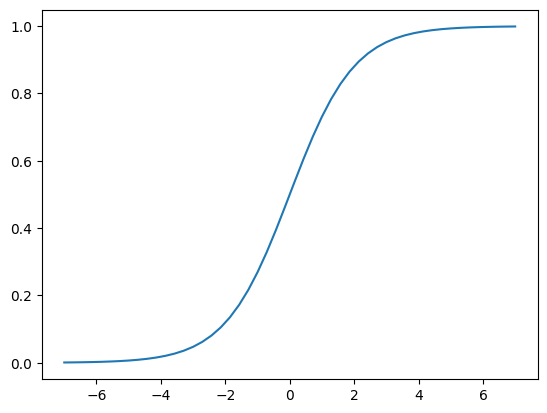

In [56]:
plt.plot(z, sigmoid(z))

In [57]:
def dot(X: np.ndarray, W: np.ndarray, b)->np.ndarray:
    n = len(X)
    result = []
    for i in range(n):
        res = 0.0
        for j in range(X.shape[1]):
            res += X[i][j] * W[j]
        result.append(res)
    return np.array(result)

def logistic_regression(X:np.ndarray, W:np.ndarray, b:float)->np.ndarray:
    z = dot(X, W) + b
    return sigmoid(z)

### Train logistic regression with Scikit-Learn

In [58]:
from sklearn.linear_model import LogisticRegression

In [59]:
X_val

array([[1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        5.90000e+01, 3.00580e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        5.90000e+01, 5.59765e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        4.00000e+00, 3.32450e+02],
       ...,
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        1.00000e+00, 7.08500e+01],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 1.00000e+00,
        3.80000e+01, 3.29700e+03],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        5.70000e+01, 3.03580e+03]])

In [60]:
model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\b-cichebi\AppData\Local\anaconda3\envs\mlops-project\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [61]:
model.coef_[0].round(3)

array([ 0.548, -0.207, -0.468, -0.051, -0.077,  0.036, -0.115, -0.049,
        0.028, -0.155, -0.307,  0.294, -0.115,  0.002, -0.216,  0.122,
       -0.034,  0.088, -0.115, -0.101,  0.239, -0.115, -0.252, -0.237,
        0.109, -0.103, -0.025, -0.112, -0.181,  0.256, -0.09 ,  0.122,
       -0.25 ,  0.177, -0.151, -0.115,  0.138, -0.066, -0.115,  0.053,
        0.203, -0.115, -0.216, -0.06 ,  0.   ])

In [62]:
model.intercept_[0]

-0.12928031756574346

In [63]:
# Probability of the positive class
y_pred =  model.predict_proba(X_val)[:, 1]

In [64]:
y_pred

array([0.14554966, 0.24658918, 0.40731794, ..., 0.71837097, 0.05766904,
       0.03169759])

In [65]:
churn_decision = (y_pred >= 0.5)

In [66]:
churn_decision.astype(int)

array([0, 0, 0, ..., 1, 0, 0])

In [67]:
(y_val == churn_decision).mean()

0.8019872249822569

In [68]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [69]:
df_pred

,probability,prediction,actual,correct
0,0.145550,0,0,True
1,0.246589,0,0,True
2,0.407318,0,1,False
3,0.562784,1,1,True
4,0.048938,0,0,True
...,...,...,...,...
1404,0.064939,0,1,False
1405,0.311335,0,0,True
1406,0.718371,1,1,True
1407,0.057669,0,0,True


### Model Interpretation

In [70]:
dict(zip(dv.get_feature_names_out(), model.coef_[0]))

{'contract=month-to-month': 0.5477071526707868,
 'contract=one_year': -0.20720800793025587,
 'contract=two_year': -0.4680796351645729,
 'dependents=no': -0.05050549894387663,
 'dependents=yes': -0.07707499147860189,
 'deviceprotection=no': 0.035605110643953414,
 'deviceprotection=no_internet_service': -0.11458604312104366,
 'deviceprotection=yes': -0.04859955794291193,
 'gender=female': 0.027552542881393496,
 'gender=male': -0.15513303330329123,
 'internetservice=dsl': -0.3066877950409852,
 'internetservice=fiber_optic': 0.29369334774252615,
 'internetservice=no': -0.11458604312104366,
 'monthlycharges': 0.0019808387664503606,
 'multiplelines=no': -0.21597202540760768,
 'multiplelines=no_phone_service': 0.1223437923626781,
 'multiplelines=yes': -0.03395225737630917,
 'onlinebackup=no': 0.08808005409451035,
 'onlinebackup=no_internet_service': -0.11458604312104366,
 'onlinebackup=yes': -0.10107450139459377,
 'onlinesecurity=no': 0.2390528754198629,
 'onlinesecurity=no_internet_service':

In [71]:
small = ['contract', 'tenure', 'monthlycharges']

df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'month-to-month', 'tenure': 3, 'monthlycharges': 19.85},
 {'contract': 'one_year', 'tenure': 55, 'monthlycharges': 103.7},
 {'contract': 'month-to-month', 'tenure': 24, 'monthlycharges': 49.7},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 20.2},
 {'contract': 'two_year', 'tenure': 61, 'monthlycharges': 62.15},
 {'contract': 'two_year', 'tenure': 42, 'monthlycharges': 20.7},
 {'contract': 'month-to-month', 'tenure': 23, 'monthlycharges': 54.15},
 {'contract': 'month-to-month', 'tenure': 37, 'monthlycharges': 98.8},
 {'contract': 'one_year', 'tenure': 43, 'monthlycharges': 20.0},
 {'contract': 'month-to-month', 'tenure': 20, 'monthlycharges': 73.65}]

In [72]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')


In [73]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

DictVectorizer(sparse=False)

In [74]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [75]:
x_train_small = dv_small.transform(dicts_train_small)

In [76]:
lr = LogisticRegression()
lr.fit(x_train_small, y_train)

LogisticRegression()

In [77]:
b = lr.intercept_[0]
b

-2.5656396391459544

In [78]:
W = lr.coef_[0]
W

array([ 1.06672236, -0.02611968, -1.03209512,  0.02710035, -0.03590234])

In [79]:
dict(zip(dv_small.get_feature_names_out(), W.round(3)))

{'contract=month-to-month': 1.067,
 'contract=one_year': -0.026,
 'contract=two_year': -1.032,
 'monthlycharges': 0.027,
 'tenure': -0.036}

Understanding how the weights and bias values affect the score,
    we take the values from the cell and sum them up manually

In [80]:
''' If User has a month-to-month contract then one_year and two_year have values of 0 respectively.
    The user also pays monthly charge of $50 and a tenure of 5 years'''


z = -2.47 + (1 *1.063) + (50 * 0.027) + (5 * -0.036)
z


-0.23700000000000015

In [81]:
sigmoid(z)

0.4410257854815464

##### The probability of the customer churning is below 0.5 which can be categorized as False

### Using the model

In [145]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [146]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [147]:
y_full_train = df_full_train['churn'].values

In [148]:
model = LogisticRegression()
model.fit(X_full_train, y_full_train)

c:\Users\b-cichebi\AppData\Local\anaconda3\envs\mlops-project\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [149]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

In [150]:
X_test = dv.transform(dicts_test)

In [151]:
y_pred = model.predict_proba(X_test)[:, 1]

In [152]:
churn_decision = (y_pred >= 0.5)
(churn_decision == y_test).mean()

0.8218594748048261

In [153]:
customer_data = dicts_test[11]

In [154]:
X_customer = dv.transform([customer_data])
y_cust_pred = model.predict_proba(X_customer)[0, 1]
print(f"The predicted probability this customer is going to churn {(y_cust_pred >= 0.5).astype(int)}, The actual value of the customer {y_test[11]}")

The predicted probability this customer is going to churn 0, The actual value of the customer 0


In [155]:
(model.predict_proba(dv.transform(dicts_test[0]))[0, 1]) >= 0.5

True

In [156]:
y_test[0]

1

#### 4.1 Accuracy & Dummy Model

#### 4.2 Confusion Table/Matrix

In [157]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [158]:
threshold = 0.5
pred_positive = (y_pred >= threshold)
pred_negative = (y_pred < threshold)

In [159]:
tp = (pred_positive & actual_positive).sum()
tn = (pred_negative & actual_negative).sum()

In [160]:
fp = (pred_positive & actual_negative).sum()
fn = (pred_negative & actual_positive).sum()

In [167]:
(fn, fp ), (tn, tp)

((300, 227), (803, 79))

In [172]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]])
confusion_matrix

array([[803, 227],
       [300,  79]])

In [176]:
(confusion_matrix/ confusion_matrix.sum()).round(2)

array([[0.57, 0.16],
       [0.21, 0.06]])

#### Precision and Recall

In [181]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f"The precision and recall are ({precision:.2f}) and ({recall:.2f}) respectively")

The precision and recall are (0.26) and (0.21) respectively
